# Pipeline:

In [1]:
import json
import torch
import matplotlib.pyplot as plt


/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from scripts.reader import read_data_from_url, extract_relevant_data, shuffle_lists_together, split_graphs_dataset
from scripts.plotter import plot_distributions, plot_training_curves
from scripts.dataset import prepare_graph_dataset, load_into_dataloader
from scripts.predictor import compute_metrics_and_matrix_classification
from scripts.trainer import train_model, build_model


/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch_geometric/typing.py:18: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/libpyg.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <B5FD9895-F13C-386E-85C3-E2998159857E> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/libpyg.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch/lib/libc10.dylib
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "


### Read the data:

In [3]:
data_frame = read_data_from_url()
data_frame


,Unnamed: 0,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,0,CHEMBL63786,3.000000e-03,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.28910,True
1,1,CHEMBL35820,6.000000e-03,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.93330,True
2,2,CHEMBL53711,6.000000e-03,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5,1,3.59690,True
3,3,CHEMBL66031,8.000000e-03,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,4,2,4.01220,True
4,4,CHEMBL53753,8.000000e-03,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5,2,3.57260,True
...,...,...,...,...,...,...,...,...,...,...,...
4630,5562,CHEMBL120564,2.600000e+06,nM,COc1cc(C=C(C#N)C#N)cc(C)c1O,2.585027,214.074228,4,1,2.13978,True
4631,5563,CHEMBL66879,3.000000e+06,nM,O=C(O)/C=C/c1ccc(O)cc1,2.522879,164.047344,2,2,1.49000,True
4632,5564,CHEMBL261238,5.000000e+06,nM,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030,404.095250,6,1,5.20048,True
4633,5565,CHEMBL76587,6.500000e+06,nM,N#CC(C#N)Cc1ccc(O)cc1,2.187087,172.063663,3,1,1.59806,True


### Extract the data & shuffle the lists:

In [4]:
names_data, smile_data, pIC50_data = extract_relevant_data(data_frame=data_frame)
names_data, smile_data, pIC50_data = shuffle_lists_together(names_data, smile_data, pIC50_data)


### Split the datasets into train, valid & infer:

In [5]:
split_dataset = split_graphs_dataset(
    total_smiles_data=smile_data, 
    total_pIC50_value=pIC50_data, 
    )

train_smile_data, train_pIC50_data = split_dataset["train"]
valid_smile_data, valid_pIC50_data = split_dataset["valid"]
infer_smile_data, infer_pIC50_data = split_dataset["infer"]


### Visualise:

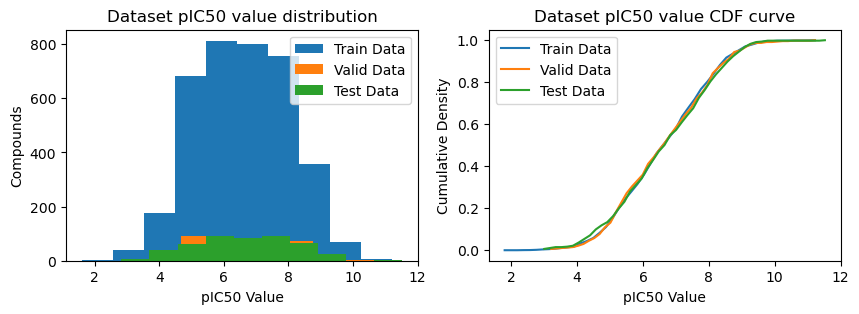

In [6]:
hist_fig = plot_distributions([train_pIC50_data, valid_pIC50_data, infer_pIC50_data], figsize=(10, 3))
plt.show()
plt.close(hist_fig)

## Create pytorch geometric dataset:

In [8]:
config = json.load(open("./results/config.json"))
config

{'batch_size': 64,
 'dropout_prob': 0.2,
 'num_features': 9,
 'num_attn_heads': 8,
 'embedding_size': 64,
 'use_batch_norm': False,
 'learning_rate': 0.001,
 'weight_decay': 1e-05,
 'scheduler_gamma': 0.99,
 'num_epochs': 500,
 'pos_class_weight': 2.5,
 'problem_type': 'classification',
 'logging_frequency': 20}

In [9]:
train_dataset = prepare_graph_dataset(train_smile_data, train_pIC50_data, problem_type=config["problem_type"])
valid_dataset = prepare_graph_dataset(valid_smile_data, valid_pIC50_data, problem_type=config["problem_type"])
infer_dataset = prepare_graph_dataset(infer_smile_data, infer_pIC50_data, problem_type=config["problem_type"])
len(train_dataset), len(valid_dataset), len(infer_dataset)


Converting SMILES strings to torch_geometric data: 100%|██████████| 3708/3708 [00:14<00:00, 262.85it/s]
Converting SMILES strings to torch_geometric data: 100%|██████████| 464/464 [00:01<00:00, 261.40it/s]
Converting SMILES strings to torch_geometric data: 100%|██████████| 463/463 [00:01<00:00, 271.12it/s]


(3708, 464, 463)

In [10]:
train_dataset[0], train_dataset[0].x.dtype, train_dataset[0].y.dtype

(Data(x=[28, 9], edge_index=[2, 62], edge_attr=[62, 3], smiles='Cc1ccc(Nc2ncc3cc(-c4c(Cl)cccc4Cl)c(=O)n(C)c3n2)cc1', y=[1]),
 torch.float32,
 torch.int64)

### Ensure label distributions are cca. i.i.d.:

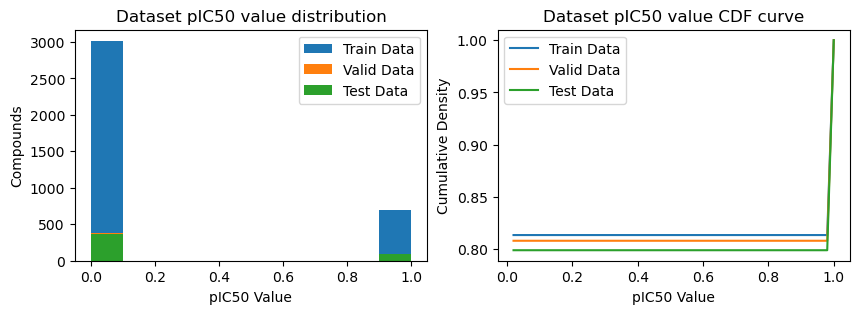

In [11]:
hist_fig = plot_distributions([
    [g.y.item() for g in train_dataset], 
    [g.y.item() for g in valid_dataset], 
    [g.y.item() for g in infer_dataset], 
], figsize=(10, 3))
plt.show()
plt.close(hist_fig)

### Wrap into the DataLoader:

In [12]:
train_loader = load_into_dataloader(train_dataset, batch_size=config["batch_size"], shuffle=True)
valid_loader = load_into_dataloader(valid_dataset, batch_size=config["batch_size"], shuffle=False)
infer_loader = load_into_dataloader(infer_dataset, batch_size=config["batch_size"], shuffle=False)


## Build the GNN model & train:

### Define loss criterion for model training:

In [13]:
weight = torch.Tensor([1.0, config["pos_class_weight"]])  # Adjust the value as needed
loss_fn = torch.nn.CrossEntropyLoss(weight=weight)
weight, loss_fn

(tensor([1.0000, 2.5000]), CrossEntropyLoss())

In [14]:
gat_model, gat_optimizer, gat_scheduler = build_model(
    num_features=config["num_features"], 
    embedding_size=config["embedding_size"], 
    num_heads=config["num_attn_heads"], 
    dropout_prob=config["dropout_prob"],
    use_batch_norm=config["use_batch_norm"],
    learning_rate=config["learning_rate"],
    weight_decay=config["weight_decay"],
    scheduler_gamma=config["scheduler_gamma"],
)

GAT model architecture:  GAT(
  (gat1): GATv2Conv(9, 64, heads=8)
  (gat2): GATv2Conv(512, 64, heads=4)
  (gat3): GATv2Conv(256, 64, heads=1)
  (out): Linear(in_features=128, out_features=2, bias=True)
)
Number of parameters:  307714


### Train the model:

In [15]:
results = train_model(
    gat_model, 
    loss_fn,
    gat_optimizer, 
    gat_scheduler,    
    train_loader = train_loader, 
    valid_loader = valid_loader, 
    infer_loader = infer_loader, 
    num_epochs = config["num_epochs"], 
    logger_freq = config["logging_frequency"], 
)


Starting training... for 500 epochs	 Validation = INCLUDED

Epoch 0 | Learning rate: 0.001000 | Train Loss 0.6746 | Train Metric 0.78 | Valid Loss 0.6448 | Valid Metric 0.82 |
Epoch 20 | Learning rate: 0.000818 | Train Loss 0.6248 | Train Metric 0.76 | Valid Loss 0.6018 | Valid Metric 0.82 |
Epoch 40 | Learning rate: 0.000669 | Train Loss 0.5817 | Train Metric 0.74 | Valid Loss 0.5634 | Valid Metric 0.71 |
Epoch 60 | Learning rate: 0.000547 | Train Loss 0.5559 | Train Metric 0.77 | Valid Loss 0.5323 | Valid Metric 0.70 |
Epoch 80 | Learning rate: 0.000448 | Train Loss 0.5262 | Train Metric 0.76 | Valid Loss 0.4890 | Valid Metric 0.75 |
Epoch 100 | Learning rate: 0.000366 | Train Loss 0.5198 | Train Metric 0.77 | Valid Loss 0.4771 | Valid Metric 0.77 |
Epoch 120 | Learning rate: 0.000299 | Train Loss 0.5057 | Train Metric 0.78 | Valid Loss 0.4827 | Valid Metric 0.76 |
Epoch 140 | Learning rate: 0.000245 | Train Loss 0.4991 | Train Metric 0.79 | Valid Loss 0.4847 | Valid Metric 0.73 |
Ep

## Evaluate performance:

In [16]:
pre_trained_model, train_losses, train_metric, valid_losses, valid_metric, infer_loss, infer_metr = results
pre_trained_model.eval()


GAT(
  (gat1): GATv2Conv(9, 64, heads=8)
  (gat2): GATv2Conv(512, 64, heads=4)
  (gat3): GATv2Conv(256, 64, heads=1)
  (out): Linear(in_features=128, out_features=2, bias=True)
)

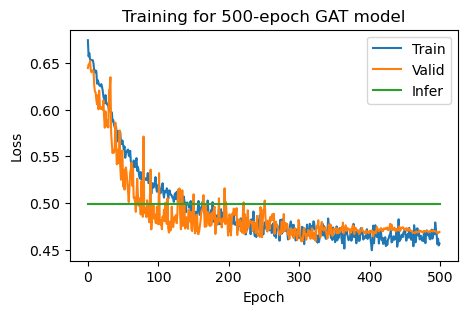

In [17]:
loss_fig = plot_training_curves(train_losses, valid_losses, infer_loss, figsize=(5, 3))
plt.savefig("./results/training_loss.png")
plt.show()
plt.close(hist_fig)

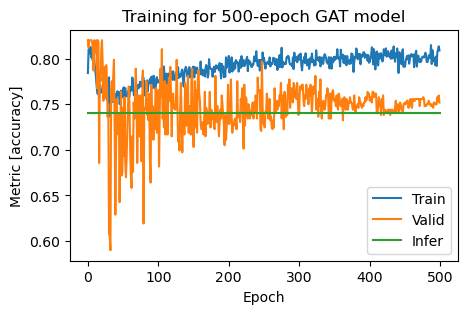

In [18]:
loss_fig = plot_training_curves(train_metric, valid_metric, infer_metr, figsize=(5, 3))
plt.ylabel("Metric [accuracy]")
plt.savefig("./results/training_metric.png")
plt.show()
plt.close(hist_fig)

### Evaluate metrics:

Inference metrics: {'accuracy': 0.7408207343412527, 'precision': 0.42011834319526625, 'recall': 0.7634408602150538, 'f1score': 0.5419847328244275}


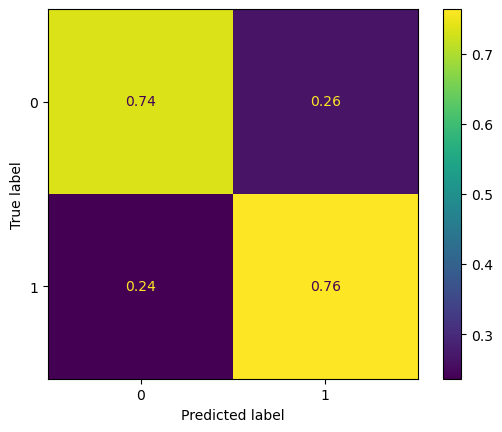

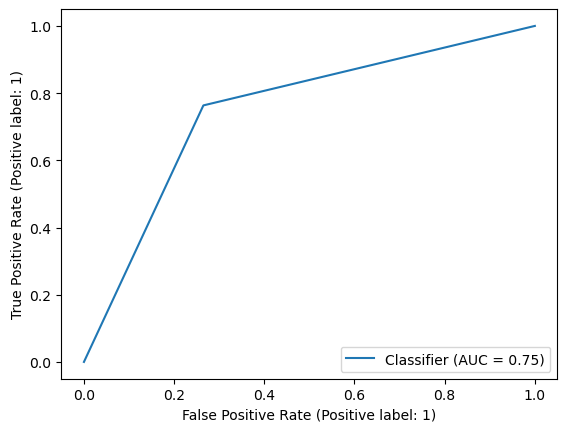

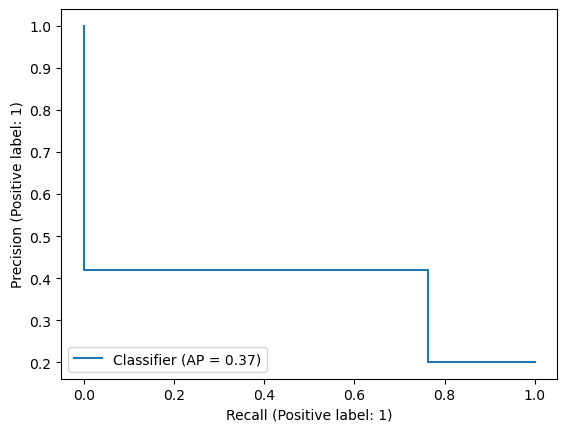

In [20]:
metrics, conf_matrix, auroc_curve, avg_pred_curve = compute_metrics_and_matrix_classification(
    data_loader=infer_loader, pre_trained_model=pre_trained_model,
)

print (f"Inference metrics: {metrics}")

conf_matrix.plot(cmap="copper")
plt.title("Confusion Matrix")
plt.savefig("./results/infer_confusion_matrix.png")
plt.close()

auroc_curve.plot()
plt.title("Area Under ROC Curve")
plt.savefig("./results/infer_area_under_curve.png")
plt.close()

avg_pred_curve.plot()
plt.title("Precision Recall Curve")
plt.savefig("./results/infer_precision_recall_curve.png")
plt.close()
    

### Save the model & resulting metrics as appropriate:

In [21]:
torch.save(pre_trained_model, "./results/classifier.pt")

with open("./results/metrics.json", "w") as outfile:
    json.dump(metrics, outfile, indent=4)


### Done!